In [247]:
import pandas as pd
import numpy as np
import teradata
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use('ggplot')
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

# connect to Mosaic database

In [248]:
username,password='MOSSASOPAAPP10','WLsNiXJ4'
udaExec = teradata.UdaExec (appName="test", version="1.0",logConsole=False) 
session=udaExec.connect(method="odbc",system='edtdpAP1', username=username,password=password, autocommit=True,transactionMode="Teradata")

In [249]:
query1="""
SELECT SCHD_LEG_DEP_DT,FLT_NUM,SKD_DEST,Floor(SKDOUT/60) AS HR,
Count(*) AS PAX,
Sum(CASE WHEN PAX_TRAVEL_TYPE_CD='E' THEN 1 ELSE 0 END) AS NONREV,
Sum(CASE WHEN PAX_TRAVEL_TYPE_CD='S' THEN 1 ELSE 0 END) AS STANDBY,
Sum(CASE WHEN INBND_ARVL_DT IS NULL THEN 0 ELSE 1 END) AS CNX,
Count(DISTINCT PNR) AS GRP,
Max(CHECKIN_TO_TARGET) AS FRS_SCAN,
Sum(CASE WHEN FARE_CLASS_CD='B' THEN 1 ELSE 0 END) AS BE,
Sum(CASE WHEN CHECKIN_TO_TARGET>=30 THEN 1 ELSE 0 END) AS FRS_FIVE,
Sum(CASE WHEN CHECKIN_TO_TARGET<30 AND CHECKIN_TO_TARGET>=25 THEN 1 ELSE 0 END) AS SCD_FIVE,
Sum(CASE WHEN CHECKIN_TO_TARGET<10 THEN 1 ELSE 0 END) AS LATE_10,
Sum(CASE WHEN CHECKIN_TO_TARGET<9 THEN 1 ELSE 0 END) AS LATE_9,
Sum(CASE WHEN CHECKIN_TO_TARGET<8 THEN 1 ELSE 0 END) AS LATE_8,
Sum(CASE WHEN CHECKIN_TO_TARGET<7 THEN 1 ELSE 0 END) AS LATE_7,
Sum(CASE WHEN CHECKIN_TO_TARGET<6 THEN 1 ELSE 0 END) AS LATE_6,
Avg(SEATS) AS SEAT,
Avg(DPT_VAR) AS DPT_VAR,
Min(CHECKIN_TO_TARGET) AS LST_SCAN,
Avg(D0) as D0,
AVG(LF_ADJ) AS ADJ_LF,
Sum(CASE WHEN INBND_ARVL_TM IS NOT NULL AND SCHD_LEG_DEP_DT=INBND_ARVL_DT AND SKDOUT-INBND_ARVL_TM<=60 THEN 1 ELSE 0 END) AS TCNX_60,
Sum(CASE WHEN INBND_ARVL_TM IS NOT NULL AND SCHD_LEG_DEP_DT=INBND_ARVL_DT AND SKDOUT-INBND_ARVL_TM<=50 THEN 1 ELSE 0 END) AS TCNX_50,
Sum(CASE WHEN INBND_ARVL_TM IS NOT NULL AND SCHD_LEG_DEP_DT=INBND_ARVL_DT AND SKDOUT-INBND_ARVL_TM<=40 THEN 1 ELSE 0 END) AS TCNX_40,
Sum(CASE WHEN INBND_ARVL_TM IS NOT NULL AND SCHD_LEG_DEP_DT=INBND_ARVL_DT AND SKDOUT-INBND_ARVL_TM<=35 THEN 1 ELSE 0 END) AS TCNX_35
FROM PROD_FATSYS_SNBX_DB.PAX_CHECKIN_LIST
WHERE SKD_ORIG='DFW'
AND ACT_FLEET='321'
AND SCHD_LEG_DEP_DT BETWEEN '2019-01-01' AND DATE-1
AND SKD_ORIG_ENREGION=11 AND SKD_DEST_ENREGION=11
AND Substr(Coalesce(DLY_CD0,'XX'),1,2)  NOT IN ('AT','WX','MT','CX') 
AND Substr(Coalesce(DLY_CD1,'XX'),1,2)  NOT IN ('AT','WX','MT','CX') 
AND Substr(Coalesce(DLY_CD2,'XX'),1,2)  NOT IN ('AT','WX','MT','CX') 
AND Substr(Coalesce(DLY_CD3,'XX'),1,2)  NOT IN ('AT','WX','MT','CX') 
AND Substr(Coalesce(DLY_CD4,'XX'),1,2)  NOT IN ('AT','WX','MT','CX') 
AND DPT_VAR<30

GROUP BY SCHD_LEG_DEP_DT,FLT_NUM,SKD_DEST,HR
HAVING FRS_SCAN>=35"""

df=pd.read_sql_query(query1,session)

# Data manipulation and clearing

In [250]:
df=df[df['PAX']<=df['SEAT']]
df['LF']=df['PAX']/df['SEAT']*100

#define whether EOB ontime, 0=N, 1=Y
df['EOB']=np.where(df.LATE_10>=1,0,1)


df=df[df['LATE_10']<=100]
def lf(x):
    if x<75:
        return 1
    elif x<80:
        return 2
    elif x<85:
        return 3
    elif x<90:
        return 4
    elif x<95:
        return 5
    elif x<100:
        return 6
    else:
        return 7

df['LF_bucket']=df['LF'].apply(lf)
df['HR']=df['HR'].astype(int)
df['FLT_NUM']=df['FLT_NUM'].astype(int).astype(str)

In [251]:
pd.set_option('display.max_columns', None)
df.head(10)

,SCHD_LEG_DEP_DT,FLT_NUM,SKD_DEST,HR,PAX,NONREV,STANDBY,CNX,GRP,FRS_SCAN,BE,FRS_FIVE,SCD_FIVE,LATE_10,LATE_9,LATE_8,LATE_7,LATE_6,SEAT,DPT_VAR,LST_SCAN,D0,ADJ_LF,TCNX_60,TCNX_50,TCNX_40,TCNX_35,LF,EOB,LF_bucket
0,2019-01-04,2314,MCO,13,147.0,3.0,0.0,94.0,112.0,37.0,23.0,21.0,40.0,0.0,0.0,0.0,0.0,0.0,181.0,-7.0,16.0,100.0,81.22,12.0,0.0,0.0,0.0,81.215470,1,3
1,2019-01-13,2736,EWR,12,174.0,2.0,0.0,52.0,162.0,40.0,11.0,102.0,47.0,1.0,1.0,1.0,1.0,1.0,181.0,-5.0,2.0,100.0,95.03,9.0,6.0,3.0,0.0,96.132597,0,6
2,2019-04-08,1310,DCA,9,181.0,1.0,2.0,37.0,175.0,48.0,3.0,71.0,56.0,1.0,1.0,1.0,1.0,1.0,181.0,-2.0,4.0,100.0,100.00,1.0,1.0,1.0,1.0,100.000000,0,7
3,2019-01-18,334,SAT,16,175.0,6.0,3.0,146.0,153.0,37.0,60.0,77.0,54.0,1.0,1.0,1.0,1.0,1.0,181.0,-4.0,1.0,100.0,96.13,43.0,30.0,17.0,12.0,96.685083,0,6
5,2019-02-23,861,PSP,8,110.0,0.0,1.0,57.0,88.0,35.0,32.0,52.0,36.0,4.0,0.0,0.0,0.0,0.0,187.0,-3.0,9.0,100.0,57.22,34.0,25.0,11.0,11.0,58.823529,0,1
6,2019-02-26,2198,FLL,14,168.0,3.0,1.0,124.0,141.0,36.0,29.0,66.0,59.0,0.0,0.0,0.0,0.0,0.0,181.0,-5.0,17.0,100.0,92.27,28.0,16.0,3.0,0.0,92.817680,1,5
7,2019-04-10,1774,CLT,20,161.0,7.0,1.0,128.0,135.0,39.0,26.0,87.0,48.0,0.0,0.0,0.0,0.0,0.0,187.0,-4.0,18.0,100.0,85.56,3.0,0.0,0.0,0.0,86.096257,1,4
8,2019-02-08,1463,ORD,17,171.0,20.0,5.0,39.0,155.0,36.0,15.0,74.0,55.0,0.0,0.0,0.0,0.0,0.0,181.0,16.0,10.0,0.0,93.92,7.0,3.0,1.0,1.0,94.475138,1,5
10,2019-02-27,1011,LGA,16,132.0,8.0,2.0,70.0,111.0,40.0,17.0,95.0,34.0,0.0,0.0,0.0,0.0,0.0,181.0,8.0,16.0,0.0,72.93,20.0,14.0,2.0,0.0,72.928177,1,1
12,2019-04-01,1373,AUS,16,172.0,5.0,2.0,144.0,146.0,37.0,23.0,75.0,48.0,0.0,0.0,0.0,0.0,0.0,181.0,-5.0,16.0,100.0,95.03,29.0,11.0,0.0,0.0,95.027624,1,6


In [252]:
#Unbalanced dataset, If not fixed, Train and test socre are 85+

print(sum(df['EOB']==1),sum(df['EOB']==0))

4200 1684


# EDA

In [253]:
#impact on D0, 14% gap at d-10
gap=[]
for i in range(6,11):
    t='LATE_'+str(i)
    df['EOB']=np.where(df[t]>=1,0,1)
    gap.append(df[df['EOB']==1].D0.mean()-df[df['EOB']==0].D0.mean())
print(pd.Series(gap,index=range(6,11)))   #D0 drop 1% every minute 
df['EOB']=np.where(df.LATE_10>=1,0,1)

6     18.487031
7     16.740313
8     15.749899
9     15.311537
10    14.037043
dtype: float64


In [254]:
temp=pd.DataFrame(df.groupby(['HR']).agg({'D0':[len,np.mean],'EOB':[np.mean]}))
temp.columns=['n','D0','EOB']
temp

,n,D0,EOB
HR,,,
0,3.0,33.333333,1.000000
5,124.0,89.516129,0.685484
6,211.0,89.099526,0.781991
7,695.0,87.194245,0.802878
8,492.0,81.910569,0.717480
9,399.0,80.451128,0.804511
10,431.0,70.997680,0.733179
11,227.0,70.925110,0.731278
12,385.0,73.506494,0.709091


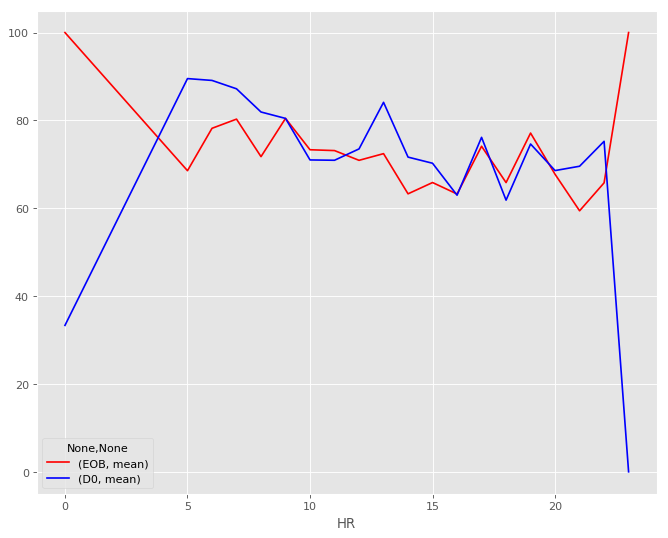

In [256]:
plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
df.groupby(['HR']).agg({'EOB':[np.mean]}).multiply(100).plot(ax=plt.gca(),color='red')
df.groupby(['HR']).agg({'D0':[np.mean]}).plot(ax=plt.gca(),color='blue')

# performance drops in afternoon 

In [257]:
df.columns

Index(['SCHD_LEG_DEP_DT', 'FLT_NUM', 'SKD_DEST', 'HR', 'PAX', 'NONREV',
       'STANDBY', 'CNX', 'GRP', 'FRS_SCAN', 'BE', 'FRS_FIVE', 'SCD_FIVE',
       'LATE_10', 'LATE_9', 'LATE_8', 'LATE_7', 'LATE_6', 'SEAT', 'DPT_VAR',
       'LST_SCAN', 'D0', 'ADJ_LF', 'TCNX_60', 'TCNX_50', 'TCNX_40', 'TCNX_35',
       'LF', 'EOB', 'LF_bucket'],
      dtype='object')

In [258]:
y=df[df['EOB']==1]
n=df[df['EOB']==0]
y=y.sample(n=len(n),replace=False)

clean=pd.concat([y,n],axis=0)
feature=clean[['HR', 'NONREV', 'STANDBY', 'CNX', 'GRP', 'FRS_SCAN', 'BE', 'FRS_FIVE', 'SCD_FIVE',
               'SEAT',  'TCNX_60', 'TCNX_50', 'TCNX_40', 'TCNX_35', 'LF','ADJ_LF']]

# Modeling 

train accurary: 0.7487008166295471
test accurary: 0.658753709198813


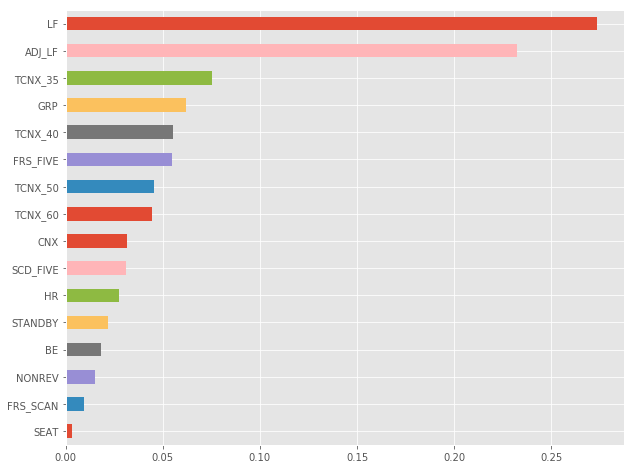

In [260]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
x_train,x_test,y_train,y_test=train_test_split(feature,clean['EOB'],test_size=0.2)
model=RandomForestClassifier(n_estimators=100,max_depth=5,min_samples_split=5)
model.fit(x_train,y_train)
print('train accurary: {}'.format(metrics.accuracy_score(y_train,model.predict(x_train))))
pd.Series(model.feature_importances_,index=x_train.columns).sort_values().plot(kind='barh',figsize=(10,8))

# LF has most impact 

print('test accurary: {}'.format(metrics.accuracy_score(y_test,model.predict(x_test))))

In [261]:
# study LF 
df.groupby(['LF_bucket']).EOB.mean()

LF_bucket
1    0.869736
2    0.880223
3    0.846154
4    0.837838
5    0.744597
6    0.597285
7    0.390411
Name: EOB, dtype: float64

train accurary: 0.7091972355130249
test accurary: 0.5923566878980892


EOB
0    1068
1    1284
Name: D0, dtype: int64

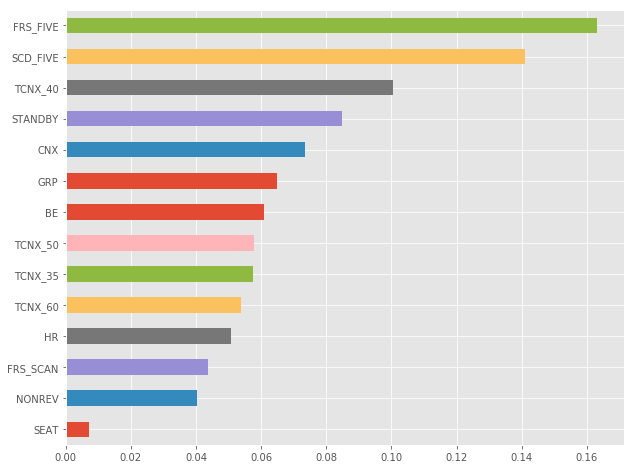

In [328]:
# study only high LF
temp=df[df['LF']>95]
y=temp[temp['EOB']==1]
n=temp[temp['EOB']==0]
#y=y.sample(n=len(n),replace=False)

clean=pd.concat([y,n],axis=0)
feature=clean[['HR', 'NONREV', 'STANDBY', 'CNX', 'GRP', 'FRS_SCAN', 'BE', 'FRS_FIVE', 'SCD_FIVE',
               'SEAT',  'TCNX_60', 'TCNX_50', 'TCNX_40', 'TCNX_35']]
x_train,x_test,y_train,y_test=train_test_split(feature,clean['EOB'],test_size=0.2)
model=RandomForestClassifier(n_estimators=100,max_depth=5,min_samples_split=5)
model.fit(x_train,y_train)
print('train accurary: {}'.format(metrics.accuracy_score(y_train,model.predict(x_train))))
pd.Series(model.feature_importances_,index=x_train.columns).sort_values().plot(kind='barh',figsize=(10,8))

# LF has most impact 

print('test accurary: {}'.format(metrics.accuracy_score(y_test,model.predict(x_test))))
temp.groupby(['EOB']).D0.count()

In [264]:
temp.groupby(['EOB']).D0.count()

EOB
0     356
1    2158
Name: D0, dtype: int64

#### High LF, the key is speed up in the first a few minutes, show have around 10 pax boarding per minute
#### Low LF, the main driver is holding for cnx, should shut down at D-10

# Plot boarding hist

In [267]:
query2="""
SELECT A.*,LF,SOB,EOB,D0,DPT_VAR
FROM 
(SELECT SCHD_LEG_DEP_DT,FLT_NUM,SKD_DEST,CHECKIN_TO_TARGET,
CASE WHEN INBND_ARVL_DT IS NOT NULL  AND SCHD_LEG_DEP_DT=INBND_ARVL_DT AND SKDOUT-INBND_ARVL_TM<=60 THEN 'TCNX' 
WHEN INBND_ARVL_DT IS NOT NULL  AND SCHD_LEG_DEP_DT=INBND_ARVL_DT AND SKDOUT-INBND_ARVL_TM>60 THEN 'NCNX' 
WHEN INBND_ARVL_DT IS NULL AND FARE_CLASS_CD='B' THEN 'BE' WHEN INBND_ARVL_DT IS NULL AND PAX_TRAVEL_TYPE_CD='E' THEN 'NONREV' ELSE 'OTHER' END AS PAX_TRAVEL_TYPE_CD,
Count(*) AS NUM
FROM PROD_FATSYS_SNBX_DB.PAX_CHECKIN_LIST
WHERE SKD_ORIG='PHL'
AND ACT_FLEET='321'
AND SCHD_LEG_DEP_DT BETWEEN '2019-01-01' AND DATE-1
AND SKD_ORIG_ENREGION=11 AND SKD_DEST_ENREGION=11
AND Substr(Coalesce(DLY_CD0,'XX'),1,2)  NOT IN ('AT','WX','MT','CX') 
AND Substr(Coalesce(DLY_CD1,'XX'),1,2)  NOT IN ('AT','WX','MT','CX') 
AND Substr(Coalesce(DLY_CD2,'XX'),1,2)  NOT IN ('AT','WX','MT','CX') 
AND Substr(Coalesce(DLY_CD3,'XX'),1,2)  NOT IN ('AT','WX','MT','CX') 
AND Substr(Coalesce(DLY_CD4,'XX'),1,2)  NOT IN ('AT','WX','MT','CX') 
GROUP BY SCHD_LEG_DEP_DT,FLT_NUM,SKD_DEST,CHECKIN_TO_TARGET,
CASE WHEN INBND_ARVL_DT IS NOT NULL  AND SCHD_LEG_DEP_DT=INBND_ARVL_DT AND SKDOUT-INBND_ARVL_TM<=60 THEN 'TCNX' 
WHEN INBND_ARVL_DT IS NOT NULL  AND SCHD_LEG_DEP_DT=INBND_ARVL_DT AND SKDOUT-INBND_ARVL_TM>60 THEN 'NCNX' 
WHEN INBND_ARVL_DT IS NULL AND FARE_CLASS_CD='B' THEN 'BE' WHEN INBND_ARVL_DT IS NULL AND PAX_TRAVEL_TYPE_CD='E' THEN 'NONREV' ELSE 'OTHER' END) AS A
JOIN
(SELECT SCHD_LEG_DEP_DT,FLT_NUM,SKD_DEST,
Sum(CASE WHEN PAX_CHECKIN_TMS<=TARGET_TMS-INTERVAL '35' MINUTE THEN 1 ELSE 0 END) AS SOB,
Sum(CASE WHEN PAX_CHECKIN_TMS>TARGET_TMS-INTERVAL '10' MINUTE THEN 1 ELSE 0 END) AS EOB,
Avg(LF_ADJ) AS LF,
AVG(D0) AS D0,
AVG(DPT_VAR) AS DPT_VAR
FROM PROD_FATSYS_SNBX_DB.PAX_CHECKIN_LIST
WHERE SKD_ORIG='PHL'
AND ACT_FLEET='321'
AND SCHD_LEG_DEP_DT BETWEEN '2019-01-01' AND DATE-1
AND SKD_ORIG_ENREGION=11 AND SKD_DEST_ENREGION=11
GROUP BY SCHD_LEG_DEP_DT,FLT_NUM,SKD_DEST
) AS B
ON A.SCHD_LEG_DEP_DT=B.SCHD_LEG_DEP_DT
AND A.FLT_NUM=B.FLT_NUM
AND A.SKD_DEST=B.SKD_DEST
WHERE SOB>0 AND DPT_VAR<30
"""

df2=pd.read_sql_query(query2,session)

In [268]:
df2.head()

,SCHD_LEG_DEP_DT,FLT_NUM,SKD_DEST,CHECKIN_TO_TARGET,PAX_TRAVEL_TYPE_CD,NUM,LF,SOB,EOB,D0,DPT_VAR
0,2019-04-14,973.0,ORD,15.0,BE,3.0,97.86,9.0,0.0,100.0,-7.0
1,2019-04-03,1785.0,PBI,26.0,NCNX,5.0,61.50,16.0,0.0,100.0,-12.0
2,2019-03-24,1827.0,ORD,27.0,OTHER,4.0,11.76,1.0,0.0,100.0,-12.0
3,2019-04-24,1726.0,CLT,18.0,BE,4.0,100.00,19.0,0.0,0.0,9.0
4,2019-01-08,850.0,BOS,15.0,TCNX,1.0,57.22,25.0,0.0,100.0,-8.0


In [269]:
df2['EOB']=np.where(df2.EOB>0,'N','Y')

In [270]:
## finish too late
temp=df2[df2.CHECKIN_TO_TARGET<-30]
check1=pd.DataFrame(temp.groupby(['SCHD_LEG_DEP_DT','FLT_NUM','SKD_DEST']).NUM.sum()).reset_index()
check1=check1[check1.NUM>20]
##start too early 
temp=df2[df2.CHECKIN_TO_TARGET>60]
check2=pd.DataFrame(temp.groupby(['SCHD_LEG_DEP_DT','FLT_NUM','SKD_DEST']).NUM.sum()).reset_index()
check2=check2[check2.NUM>20]

## remove too late or too early flights
check=pd.concat([check1,check2],axis=0)
check=check.drop(['NUM'],axis=1)
check['find']='Y'
df2=df2.merge(check,how='left',left_on=['SCHD_LEG_DEP_DT','FLT_NUM','SKD_DEST'],right_on=['SCHD_LEG_DEP_DT','FLT_NUM','SKD_DEST'])
df2=df2[pd.isnull(df2.find)]
df2=df2.drop(['find'],axis=1)

## only plot bording between d-40 and d+10
df2=df2[(df2['CHECKIN_TO_TARGET']>=-10)&(df2['CHECKIN_TO_TARGET']<=40)]
df2['CHECKIN_TO_TARGET']=df2['CHECKIN_TO_TARGET'].astype(int)

In [271]:
import seaborn as sns
import matplotlib.pyplot as plt
def stack(*args,**kwargs):  
    df=kwargs.pop('data')
    df.drop(['EOB'],axis=1)
    flt=len(df.groupby(['SCHD_LEG_DEP_DT','FLT_NUM','SKD_DEST']).NUM.sum())
    x=pd.DataFrame(df.groupby(['CHECKIN_TO_TARGET','PAX_TRAVEL_TYPE_CD']).NUM.sum().unstack().fillna(0)).reset_index()
    ax=x.set_index(['CHECKIN_TO_TARGET']).div(flt).plot(kind='bar',stacked=True,ax=plt.gca(),cmap='tab10')
    ax.invert_xaxis()
def plot(df):
    print(pd.DataFrame(df.groupby(['EOB','SCHD_LEG_DEP_DT','FLT_NUM','SKD_DEST']).NUM.sum()).reset_index().groupby(['EOB']).NUM.count()[::-1])
    p=sns.FacetGrid(df,col='EOB',sharex=False,size=10)
    p.map_dataframe(stack) 
    p.axes[0,0].set_ylabel('avg pax')
    p.axes[0,0].legend()
    #p.set(xlim=xlim)
    p.axes[0,0].set_xlabel('Minute to Target time')
    p.axes[0,1].set_xlabel('Minute to Target time') 
    #p.fig.legend(('Basic Economy','Connection','NonRev','Other','TCNX'),loc='best')
    p.fig.suptitle('Bording hist')

    

EOB
Y    2827
N     675
Name: NUM, dtype: int64


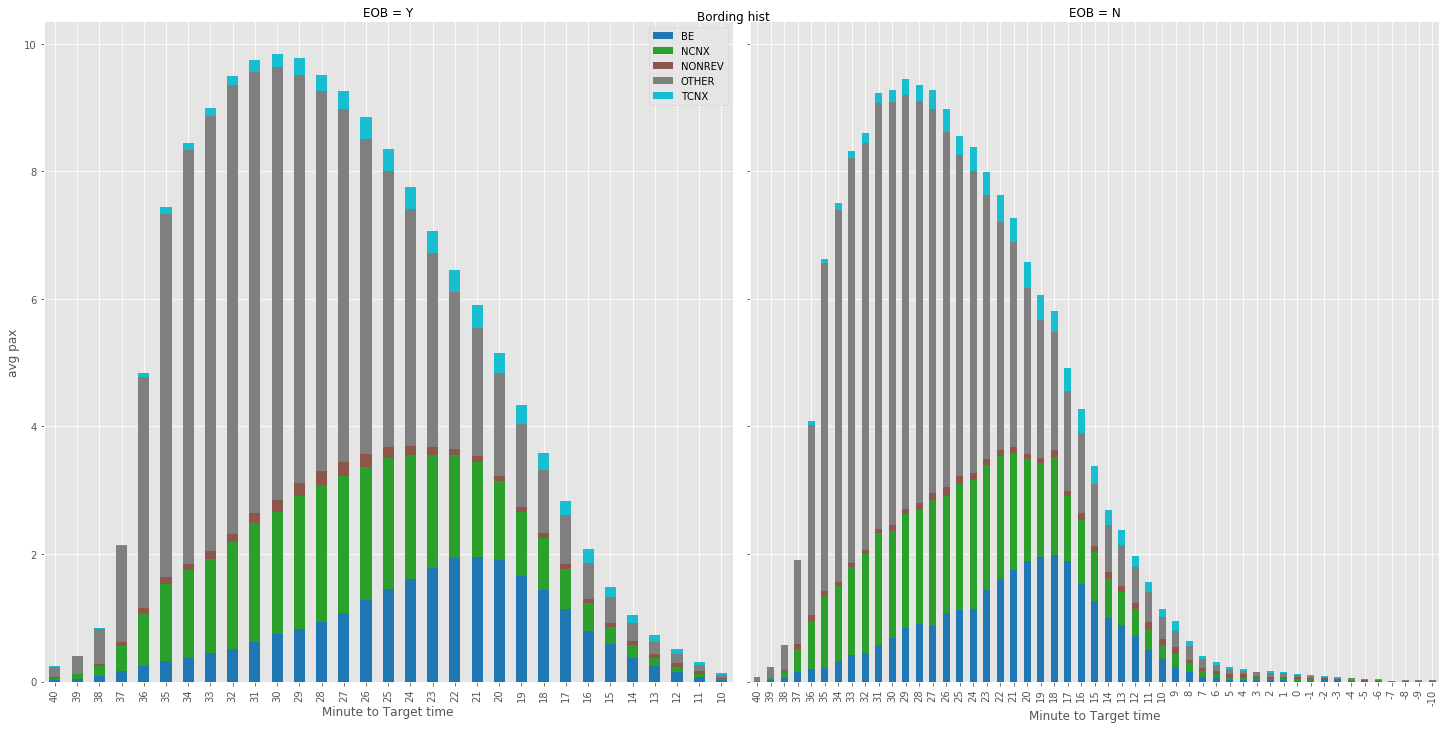

In [272]:
plot(df2)

EOB
Y    1143
N     500
Name: NUM, dtype: int64


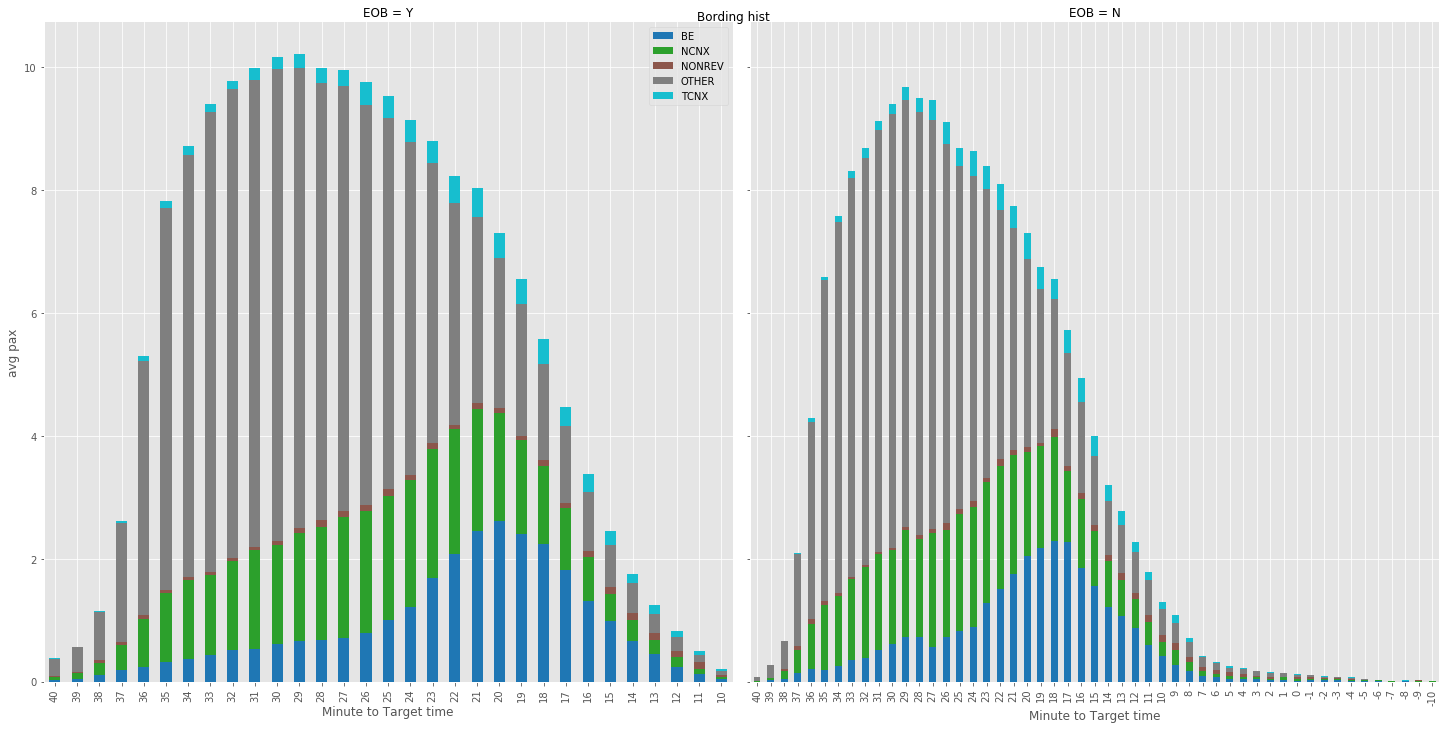

In [273]:
high_lf=df2[df2['LF']>=95]
plot(high_lf)

EOB
Y    1308
N     116
Name: NUM, dtype: int64


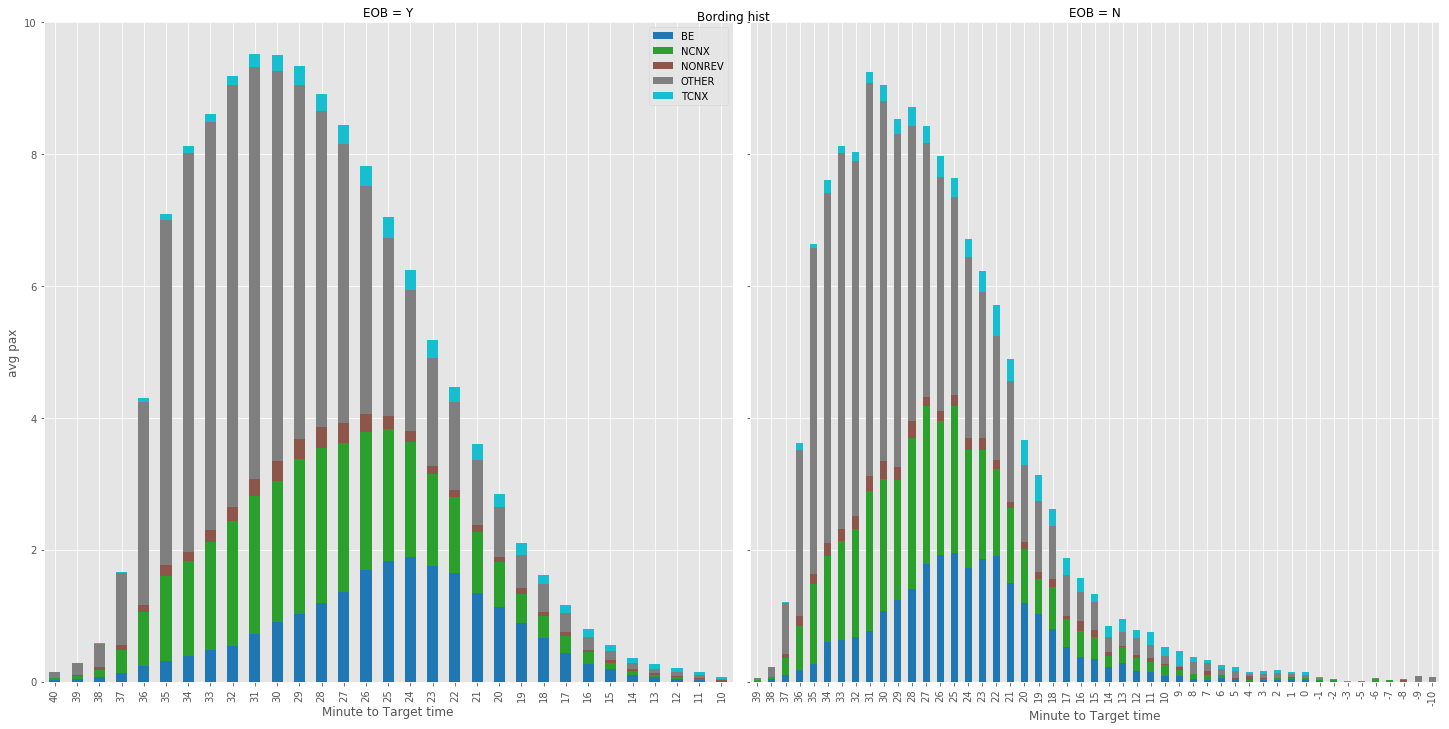

In [274]:
low_lf=df2[df2['LF']<90]
plot(low_lf)

In [275]:
def plot_flt(df):
    flt=len(df.groupby(['SCHD_LEG_DEP_DT','FLT_NUM','SKD_DEST']).NUM.count())
    df.groupby(['CHECKIN_TO_TARGET','PAX_TRAVEL_TYPE_CD']).NUM.sum().unstack().fillna(0).div(flt).plot(kind='bar',
                                                                                                      stacked=True,
                                                                                                      cmap='tab10',
                                                                                                      title='number of flight:{}'.format(flt),
                                                                                                      figsize=(15,8))
    ax=plt.gca()
    
    ax.invert_xaxis()
    ax.set_xlabel('Minute to Target time')
    ax.set_ylabel('avg pax')

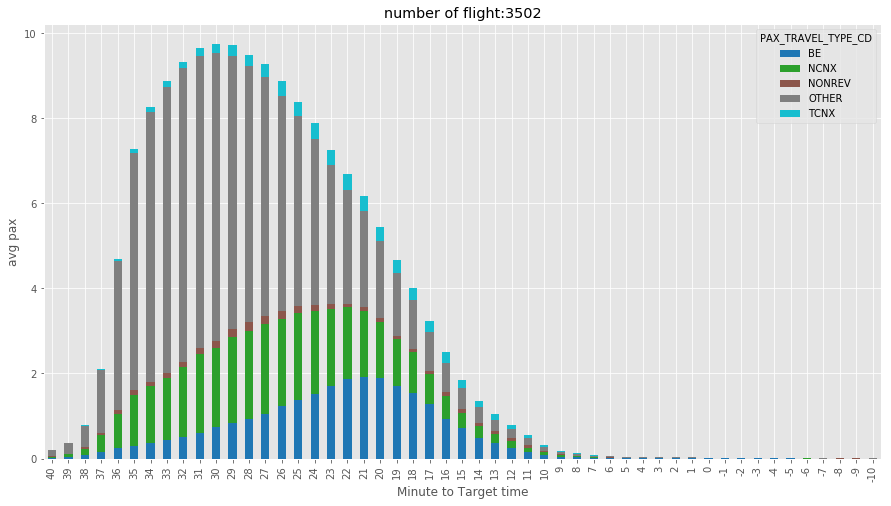

In [276]:
plot_flt(df2)

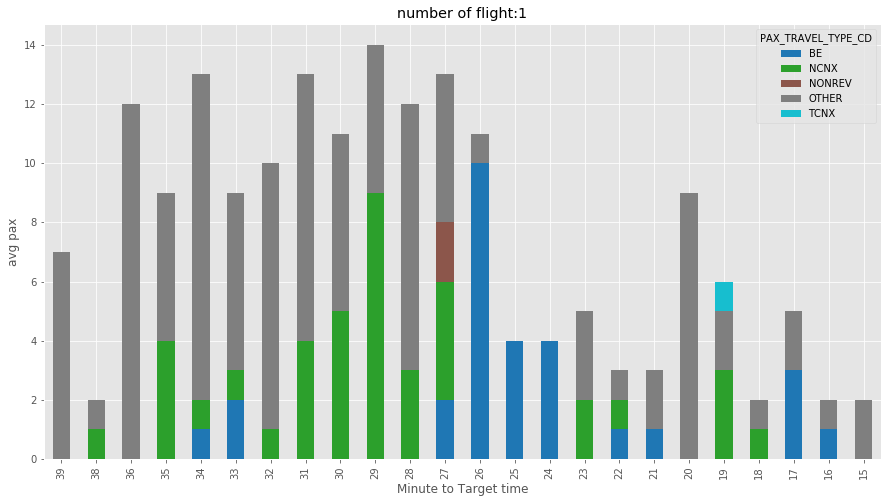

In [326]:
from datetime import date
temp=df2[(df2.SCHD_LEG_DEP_DT==date(2019,1,1))&(df2.FLT_NUM==433)]
#temp=df2[(df2.LF<90)&(df2.EOB=='N')&(df2.DPT_VAR>0)&(df2.DPT_VAR<6)]
plot_flt(temp)

In [321]:
df2[(df2.LF>95)&(df2.EOB=='N')&(df2.DPT_VAR>0)&(df2.DPT_VAR<6)].groupby(['SCHD_LEG_DEP_DT','FLT_NUM','SKD_DEST']).NUM.count()

SCHD_LEG_DEP_DT  FLT_NUM  SKD_DEST
2019-01-01       2093.0   DFW         54
2019-01-03       2060.0   ORD         62
2019-01-04       2011.0   ORD         63
2019-01-05       2011.0   ORD         61
2019-01-06       618.0    PHX         56
2019-01-07       618.0    PHX         58
                 1790.0   CLT         54
                 1997.0   LAX         53
                 2024.0   SEA         50
2019-01-09       582.0    LAX         54
2019-01-14       1821.0   CLT         51
2019-01-17       1726.0   CLT         55
                 1941.0   ORD         49
                 1997.0   LAX         55
2019-01-18       582.0    LAX         57
                 1997.0   LAX         52
2019-01-22       824.0    DFW         52
2019-01-25       1810.0   DFW         44
2019-01-28       618.0    PHX         46
2019-01-30       618.0    PHX         53
2019-02-07       1726.0   CLT         46
2019-02-09       566.0    LAX         42
2019-02-13       519.0    MCO         39
2019-02-14       582.0

In [325]:
df2[(df2.LF>95)&(df2.EOB=='Y')].groupby(['SCHD_LEG_DEP_DT','FLT_NUM','SKD_DEST']).NUM.count()

SCHD_LEG_DEP_DT  FLT_NUM  SKD_DEST
2019-01-01       433.0    PHX         48
                 566.0    LAX         43
                 593.0    SLC         44
                 677.0    SJU         42
                 794.0    DFW         57
                 809.0    TPA         45
                 1848.0   MCO         47
                 1864.0   FLL         47
                 1927.0   LAX         49
                 1970.0   PHX         42
2019-01-02       433.0    PHX         57
                 481.0    LAX         54
                 566.0    LAX         48
                 582.0    LAX         51
                 677.0    SJU         52
                 1998.0   PHX         51
                 2024.0   SEA         47
                 2060.0   ORD         46
2019-01-03       474.0    PHX         44
                 481.0    LAX         47
                 566.0    LAX         44
                 582.0    LAX         43
                 669.0    ORD         43
                 675.0